# Predictive Maintenance Workshop

This notebook is an educational walkthrough that uses the feature extraction and pipeline functions in `Preparation/Sample Preparation/Feature_extraction_pipeline` to:

1. Load and inspect audio files
2. Visualize waveforms and spectrograms
3. Extract features (MFCC + simple statistics)
4. Prepare data and train multiple models
5. Compare model performance and run inference on new audio files

Run cells sequentially. If you are missing optional packages (librosa, ipywidgets), install them first.

In [ ]:
# Basic imports and configuration
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio, display

sns.set_theme(style="whitegrid")
np.random.seed(42)

# Add local feature-extraction package to path so we can import our functions
sys.path.append(str(Path('./Preparation/Sample Preparation/Feature_extraction_pipeline').resolve()))

# Import the functions implemented in the repository
from loader import load_long_audio
from splitters import segment_train_test
from features_extractor import extract_mfcc_features, extract_features_for_list
from orchestrator import run_pipeline_on_dataset, run_pipeline_on_file
# rich_features is optional and lazily loaded by upstream orchestrator code in the repo

print('Imports OK')

# --- Pipeline parameter cell will be right below; edit it to change behavior for the whole notebook ---


Imports OK


In [2]:
# Populate `df` with audio files found under data/audio and set `data_dir`
data_dir = Path("data/audio")
_allowed_exts = {".wav", ".flac", ".mp3", ".m4a", ".ogg"}

if not data_dir.exists():
    raise SystemExit(f"Data directory not found: {data_dir}. Create it and place audio files under subfolders per-class (e.g. data/audio/<label>/*.wav)")

_records = []
for f in sorted(data_dir.rglob("*")):
    if f.is_file() and f.suffix.lower() in _allowed_exts:
        _records.append({"file_path": f, "label": f.parent.name})

df = pd.DataFrame(_records)

if df.empty:
    raise SystemExit(f"No audio files found under {data_dir}. Use extensions: {_allowed_exts}")

print(f"Found {len(df)} audio files under {data_dir}")
display(df.head())

Found 4 audio files under data/audio


,file_path,label
0,data/audio/Chipped Tooth/20250930_170743.wav,Chipped Tooth
1,data/audio/Chipped Tooth/20250930_171840.wav,Chipped Tooth
2,data/audio/Good/20250930_163202.wav,Good
3,data/audio/Good/20250930_164401.wav,Good


File: data/audio/Chipped Tooth/20250930_170743.wav  Label: Chipped Tooth
Duration: 600.00 s, SR: 40000 Hz


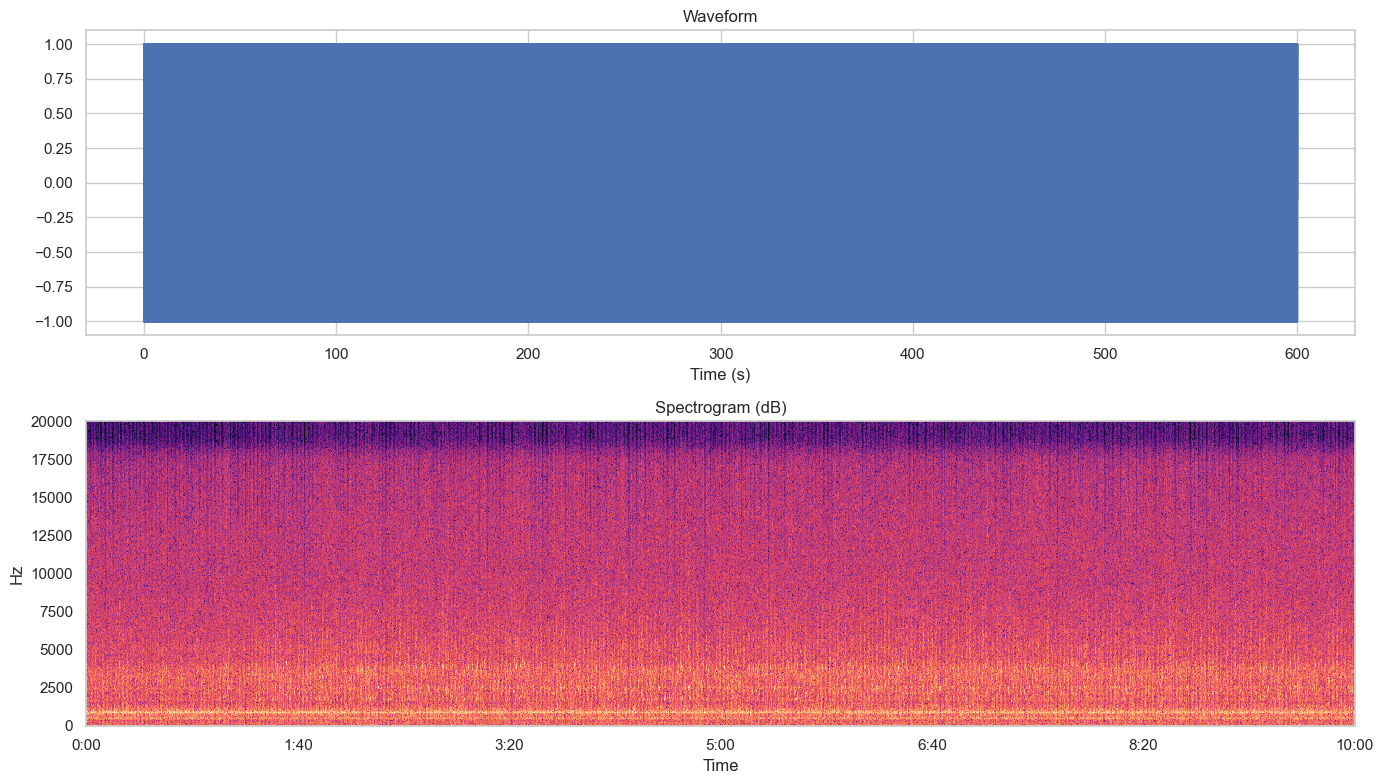

In [3]:
# Pick a sample index (change to explore other files)
if len(df) == 0:
    raise SystemExit('No audio files found in data_dir; please update the path or add samples.')

sample_idx = 0
sample_file = df.iloc[sample_idx]['file_path']
sample_label = df.iloc[sample_idx]['label']

# Load audio using the repo loader (returns mono 1-D numpy array and sr)
audio_data, sr = load_long_audio(sample_file)
print(f'File: {sample_file}  Label: {sample_label}')
print(f'Duration: {len(audio_data)/sr:.2f} s, SR: {sr} Hz')

# Play audio (small files)
#display(Audio(data=audio_data, rate=sr))

# Plot waveform + spectrogram
import librosa
import librosa.display

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
times = np.arange(len(audio_data)) / sr
ax1.plot(times, audio_data)
ax1.set_xlabel('Time (s)')
ax1.set_title('Waveform')

# Spectrogram (log amplitude)
S = np.abs(librosa.stft(audio_data, n_fft=1024, hop_length=512))
S_db = librosa.amplitude_to_db(S, ref=np.max)
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='linear', ax=ax2)
ax2.set_title('Spectrogram (dB)')
plt.tight_layout()
plt.show()

## 3) Feature extraction (MFCC demo)

We'll segment the audio into 1-second windows (50% overlap) and compute MFCC means + delta means for each segment using `extract_features_for_list`. This is the lightweight extractor present in the repo.

Produced 958 train-style segments from the sample file
Features shape: (10, 26)


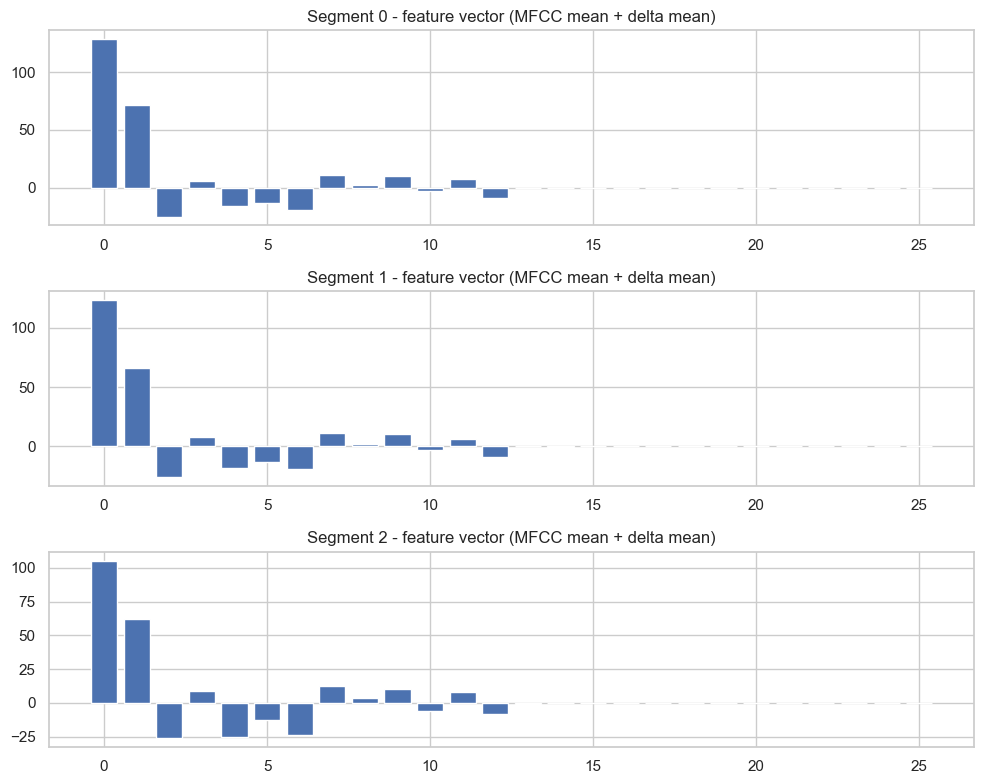

In [4]:
# Segment audio into 1s windows (train-style segmentation)
segments = segment_train_test(audio_data, sr, segment_seconds=1.0, overlap=0.5)
train_segments = segments['train']
print(f'Produced {len(train_segments)} train-style segments from the sample file')

# Extract MFCC-based features for the first few segments
X_sample, feature_names = extract_features_for_list(train_segments[:10], sr)
print('Features shape:', X_sample.shape)

# Visualize first 3 MFCC feature vectors
fig, axes = plt.subplots(3, 1, figsize=(10, 8))
for i in range(min(3, X_sample.shape[0])):
    axes[i].bar(range(X_sample.shape[1]), X_sample[i])
    axes[i].set_title(f'Segment {i} - feature vector (MFCC mean + delta mean)')
plt.tight_layout()
plt.show()

## 4) Prepare dataset for training

We'll extract features for all files, stack them into X and build y labels. Then we'll split and scale the data.

In [5]:
# Pipeline parameters (edit to change behavior for the whole notebook)
# src_dir: dataset root (expects subfolders per-class)
src_dir = data_dir  # reuse data_dir defined earlier (Path)

# Segmentation / splitting parameters
segment_seconds = 5    # length of segments in seconds
overlap = 0.5            # fraction overlap between segments (0.0 - 1.0)
train_fraction = 0.8     # fraction of data/time used for training per-file splitting
buffer_seconds = 0.0     # seconds to exclude from file boundaries when splitting

# Feature extraction level understood by the orchestrator (common values: 'segment', 'file', etc.)
feature_level = "standard"  #chose from "basic", "standard", "advanced"

print("Pipeline parameters set:",
    dict(src_dir=src_dir, segment_seconds=segment_seconds, overlap=overlap,
         train_fraction=train_fraction, buffer_seconds=buffer_seconds, feature_level=feature_level))

Pipeline parameters set: {'src_dir': PosixPath('data/audio'), 'segment_seconds': 5, 'overlap': 0.5, 'train_fraction': 0.8, 'buffer_seconds': 0.0, 'feature_level': 'standard'}


In [6]:
# Use run_pipeline_on_dataset to extract features per file and respect the orchestrator's train/test splitting

def build_dataset_with_orchestrator(src_dir: Path, segment_seconds=segment_seconds, overlap=overlap, train_fraction=train_fraction, buffer_seconds=buffer_seconds, feature_level=feature_level):
    """Run the orchestrator over the dataset directory and return stacked train/test datasets.

    Defaults reference the top-level variables so changing them above changes the whole notebook.
    """
    result = run_pipeline_on_dataset(src_dir, segment_seconds=segment_seconds, overlap=overlap, train_fraction=train_fraction, buffer_seconds=buffer_seconds, feature_level=feature_level)
    X_train = result['train']['X']
    y_train = np.array(result['train']['y'])
    X_test = result['test']['X']
    y_test = np.array(result['test']['y'])
    return X_train, y_train, X_test, y_test, result

# Run orchestrator on the dataset directory (this will segment per-file and extract richer features when available)
print('Running pipeline on dataset with parameters:', dict(segment_seconds=segment_seconds, overlap=overlap, train_fraction=train_fraction, buffer_seconds=buffer_seconds, feature_level=feature_level))
X_train, y_train, X_test, y_test, pipeline_result = build_dataset_with_orchestrator(data_dir)
print('Train X shape:', X_train.shape, 'Test X shape:', X_test.shape)

# Keep the feature names if provided
feat_names = pipeline_result['train'].get('feature_names')
if feat_names:
    print('Feature names available, count =', len(feat_names))
else:
    print('Feature names not available from extractor; using positional indices')


Running pipeline on dataset with parameters: {'segment_seconds': 5, 'overlap': 0.5, 'train_fraction': 0.8, 'buffer_seconds': 0.0, 'feature_level': 'standard'}


/Users/ibrahimelkhatib/Desktop/Fall2025/Predictive Maintenance/FrED-Predictive-Maintenance-/Preparation/Sample Preparation/Feature_extraction_pipeline/rich_features.py:234: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)


Train X shape: (572, 443) Test X shape: (72, 443)
Feature names available, count = 443


In [7]:
# No manual train/test split here — the orchestrator already produced time-contiguous splits per file
from sklearn.preprocessing import StandardScaler

if X_train.size == 0 and X_test.size == 0:
    raise SystemExit('No features extracted — check the dataset and feature extractor')

scaler = StandardScaler()
if X_train.size:
    X_train_scaled = scaler.fit_transform(X_train)
else:
    X_train_scaled = X_train
if X_test.size:
    X_test_scaled = scaler.transform(X_test)
else:
    X_test_scaled = X_test

print('Train shape:', X_train_scaled.shape, 'Test shape:', X_test_scaled.shape)


Train shape: (572, 443) Test shape: (72, 443)


## 5) Train models and evaluate

We'll train three models: RandomForest, SVM, and a small MLP. For speed in a teaching environment, defaults are modest.

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42,verbose=1),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}
results = {}
for name, model in models.items():
    print('Training', name)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    results[name] = {'model': model, 'accuracy': acc, 'report': classification_report(y_test, y_pred), 'confusion': confusion_matrix(y_test, y_pred)}
    print(f'{name} acc: {acc:.4f}')

# Summarize accuracies
for name, r in results.items():
    print(name, '->', r['accuracy'])

Training Random Forest
Random Forest acc: 1.0000
Training SVM


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


SVM acc: 1.0000
Training MLP
MLP acc: 1.0000
Random Forest -> 1.0
SVM -> 1.0
MLP -> 1.0


In [9]:
# select the trained model with highest recorded accuracy in `results`
best_name, best_info = max(results.items(), key=lambda kv: kv[1]['accuracy'])
best_model = best_info['model']
acc = float(best_info.get('accuracy', np.nan))

# update y_pred_best using the selected model (uses X_test_scaled from notebook)
try:
    y_pred_best = best_model.predict(X_test_scaled)
except Exception as e:
    # if prediction fails, keep previous y_pred_best if present and warn
    print(f"Warning: could not predict with selected model {best_name}: {e}")
else:
    print(f"Selected best model: {best_name} (accuracy={acc:.4f})")

Selected best model: Random Forest (accuracy=1.0000)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


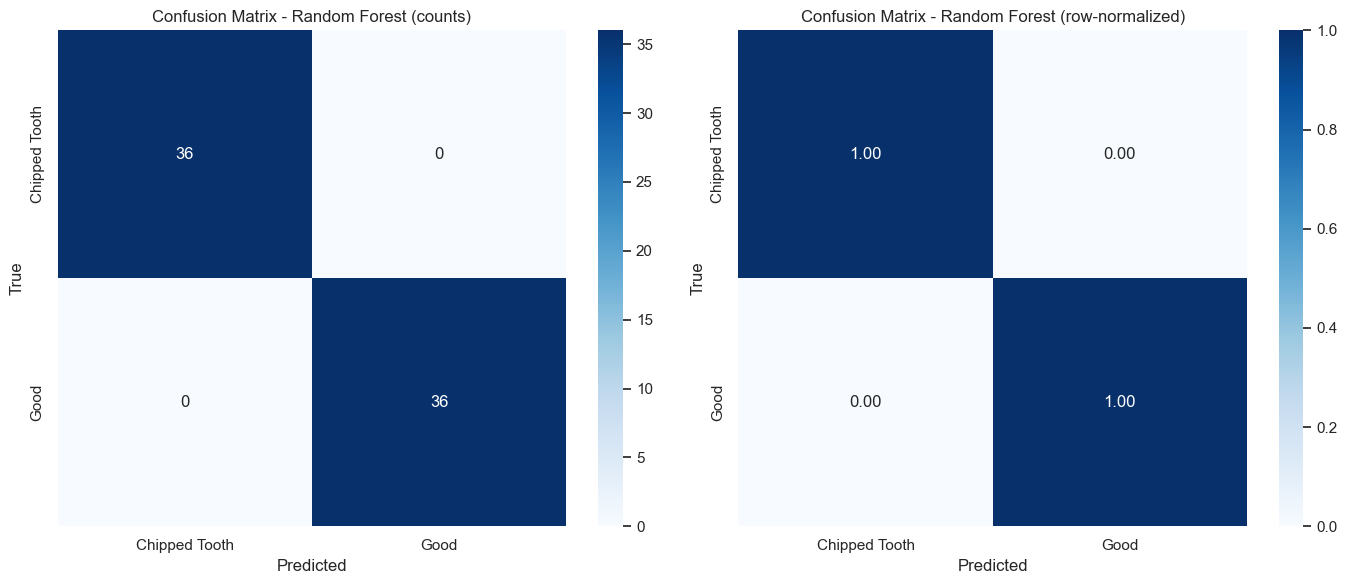

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix heatmaps for all classes (counts and row-normalized)
# Uses existing variables from the notebook if available: classes_all, y_test, y_pred_best, cm_all, cm_all_norm

import matplotlib.pyplot as plt

# determine class order
labels = sorted(np.unique(np.concatenate([np.asarray(y_test), np.asarray(y_pred_best)])))

# predictions (fallback to best_model if y_pred_best missing)
if 'y_pred_best' in globals() and np.asarray(y_pred_best).shape[0] == np.asarray(y_test).shape[0]:
    y_pred = np.asarray(y_pred_best)
else:
    # try to predict using best_model and X_test_scaled
    try:
        y_pred = best_model.predict(X_test_scaled)
    except Exception:
        raise RuntimeError("y_pred_best missing and best_model/X_test_scaled prediction failed.")

# confusion matrices (counts + row-normalized)
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Safe row normalization (avoid divide-by-zero)
row_sums = cm.sum(axis=1, keepdims=True).astype(float)
with np.errstate(divide='ignore', invalid='ignore'):
    cm_norm = np.divide(cm, row_sums, where=row_sums != 0)
    cm_norm = np.nan_to_num(cm_norm)

# Plot heatmaps
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axs[0])
axs[0].set_title(f'Confusion Matrix - {best_name} (counts)')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axs[1])
axs[1].set_title(f'Confusion Matrix - {best_name} (row-normalized)')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')

plt.tight_layout()
plt.show()

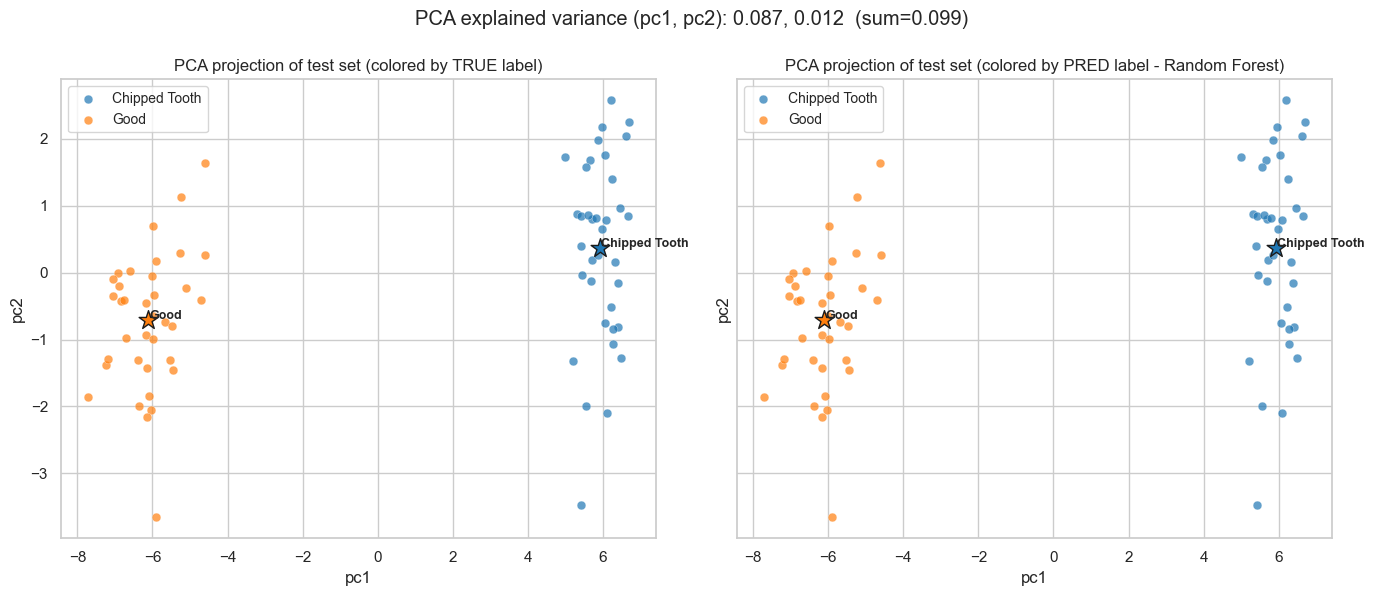

In [ ]:
from sklearn.decomposition import PCA as _PCA

# PCA-like 2D projection of the test set (unsupervised: PCA fit on train if available, otherwise on test)

# use existing pca if present, otherwise create one
pca = _PCA(n_components=2, random_state=42)

# fit PCA on train (preferred) or on test if train not available
if 'X_train_scaled' in globals() and getattr(X_train_scaled, "size", 0):
    pca.fit(X_train_scaled)
    proj = pca.transform(X_test_scaled)
else:
    proj = pca.fit_transform(X_test_scaled)

# build DataFrame for plotting
df_proj = pd.DataFrame(proj, columns=['pc1', 'pc2'])
df_proj['true'] = y_test
df_proj['pred'] = y_pred_best

# centroids per true class
centroids = df_proj.groupby('true')[['pc1', 'pc2']].mean()

# colors for classes (preserve order: model classes first if present)
labels_plot = list(dict.fromkeys(list(best_model.classes_) + list(np.unique(y_test).tolist())))
palette = sns.color_palette("tab10", n_colors=len(labels_plot))
color_map = {lab: palette[i] for i, lab in enumerate(labels_plot)}

# plot: left = colored by TRUE, right = colored by PRED (best model)
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
for ax, col, title in zip(axs, ['true', 'pred'], ['PCA projection of test set (colored by TRUE label)', f'PCA projection of test set (colored by PRED label - {best_name})']):
    for lab in labels_plot:
        sel = df_proj[col] == lab
        if sel.any():
            ax.scatter(df_proj.loc[sel, 'pc1'], df_proj.loc[sel, 'pc2'], s=40, color=color_map[lab], label=lab, alpha=0.7, edgecolor='w', linewidth=0.3)
    # highlight misclassified points on the PRED plot
    if col == 'pred':
        mis = df_proj['true'] != df_proj['pred']
        if mis.any():
            ax.scatter(df_proj.loc[mis, 'pc1'], df_proj.loc[mis, 'pc2'], facecolors='none', edgecolors='red', s=80, linewidths=1.2, label='misclassified')
    # draw centroids
    for lab, row in centroids.iterrows():
        if lab in color_map:
            ax.scatter(row['pc1'], row['pc2'], marker='*', s=200, color=color_map[lab], edgecolor='k')
            ax.text(row['pc1'] + 0.02, row['pc2'] + 0.02, str(lab), fontsize=9, weight='bold')
    ax.set_title(title)
    ax.set_xlabel('pc1')
    ax.set_ylabel('pc2')
    ax.legend(loc='best', fontsize='small')

explained = pca.explained_variance_ratio_
plt.suptitle(f'PCA explained variance (pc1, pc2): {explained[0]:.3f}, {explained[1]:.3f}  (sum={explained[:2].sum():.3f})', y=0.99)
plt.tight_layout()
plt.show()


## 6) Batch prediction on new sample set

We will now run the best-performing model from this notebook on a separate set of unlabeled (or validation) samples located under `sample_data/audio/`.

Folder structure is expected as:
```
sample_data/audio/<label_name>/*.wav
```
Each folder name will be treated as the ground-truth class for evaluation. We will:
1. Discover all audio files.
2. Load + resample them with the shared loader (fixed 40 kHz).
3. Segment and extract features using the same parameters (`segment_seconds`, `overlap`, `feature_level`).
4. Predict per-segment and aggregate to a file-level prediction (mean probability or majority vote).
5. Produce a results DataFrame and overall accuracy (if labels are available via folder names).
6. Show a confusion matrix.


,file,true_label,prediction,confidence,n_segments,n_features_extracted
0,/Users/ibrahimelkhatib/Desktop/Fall2025/Predic...,Chipped Tooth,Chipped Tooth,0.99,7,443
1,/Users/ibrahimelkhatib/Desktop/Fall2025/Predic...,Chipped Tooth,Chipped Tooth,0.99,1,443
2,/Users/ibrahimelkhatib/Desktop/Fall2025/Predic...,Chipped Tooth,Chipped Tooth,0.99,5,443


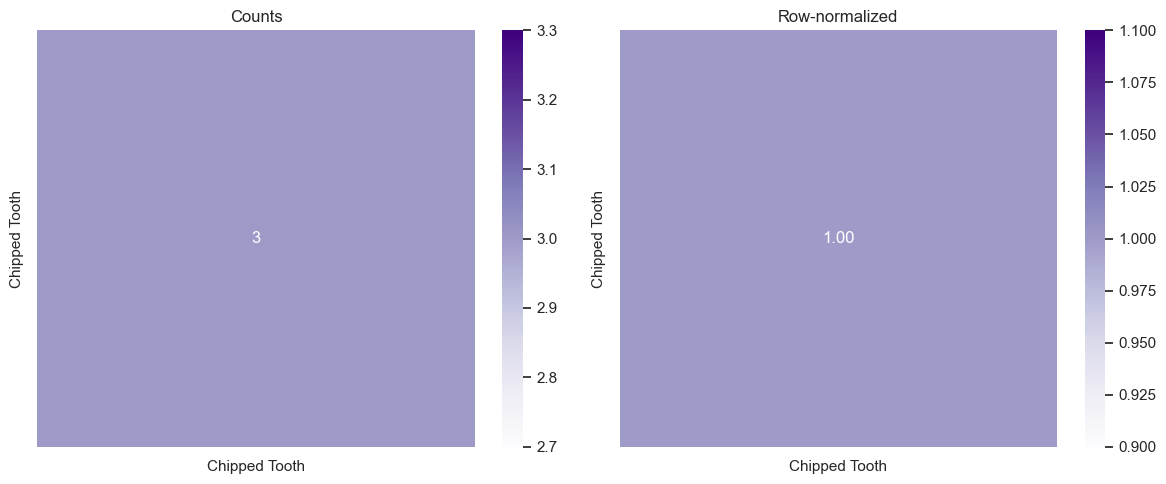

In [38]:
# Batch prediction UI using external helper script (isolated import of batch_predict only)
from pathlib import Path
import importlib.util

# Dynamically load batch_predict WITHOUT adding the whole Models directory to sys.path
_bp_path = Path('Preparation/Sample Preparation/Models/batch_predict.py').resolve()
if not _bp_path.exists():
    raise FileNotFoundError(f'Cannot locate batch_predict.py at {_bp_path}')
_spec = importlib.util.spec_from_file_location('batch_predict_ui', str(_bp_path))
_bp_mod = importlib.util.module_from_spec(_spec)
_spec.loader.exec_module(_bp_mod)  # type: ignore[attr-defined]
render_batch_prediction_ui = getattr(_bp_mod, 'render_batch_prediction_ui')

# Reuse variables from notebook; ensure best_model & scaler exist
if 'best_model' not in globals() or 'scaler' not in globals():
    raise RuntimeError('Train models first so best_model and scaler are defined.')


# Only the in-notebook trained best_model is used for inference below.
ui_batch = render_batch_prediction_ui(
    best_model=best_model,
    scaler=scaler,
    segment_seconds=segment_seconds,
    overlap=overlap,
    feature_level=feature_level,
    train_feat_names=feat_names if 'feat_names' in globals() else None,
    sample_root=Path('sample_data/audio'),
)
ui_batch